In [65]:
# 필요한 모듈을 import 하기
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [66]:
# 모델의 학습에 STL10 Dataset을 이용할 것이다
# STL10 Dataset를 저장할 Directory를 명시하도록 하자
path2data = "./data"

if not os.path.exists(path2data):
  os.mkdir(path2data)

In [67]:
# Data 전처리하기 위한 Pre-processor를 정의한다
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# STL10 Dataset중 train_dataset loading
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transform)

Files already downloaded and verified


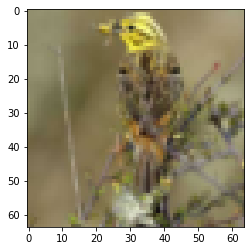

In [68]:
# 샘플 이미지를 확인해보자
img, label = train_ds[0]
plt.imshow(to_pil_image(0.5*img+0.5))

In [69]:
# Dataset을 Batch_size만큼 불러 올 DataLoader를 생성하기
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [70]:
# 모델을 정의한다
# 모델에 사용되는 여러 Parameter변수들을 정의한다
params = {'nz':100, # noise Vector의 차원
          'ngf':64, # Generator에서 사용하는 Conv filter개수
          'ndf':64, # Discriminator에서 사용하는 Conv filter개수
          'img_channel':3 # 이미지 채널
          }

In [71]:
# NoiseVector를 입력받아 가짜 이미지를 생성하는 Generator를 구현한다
# noise vector 1*1을 점차 upsampling시켜 64*64의 형태로 만든다
class Generator(nn.Module):
  def __init__(self,params):
    super().__init__()
    nz = params['nz']
    ngf = params['ngf']
    img_channel = params['img_channel']

    # 입력은 (batch_size, nz, 1, 1)
    # 왜 출력값이 이렇게 나오는지는 Note의 DCGAN편 참조하기
    self.dconv1 = nn.ConvTranspose2d(nz, ngf*8, 4, stride=1, padding=0, bias=False) # (512,4,4)
    self.bn1 = nn.BatchNorm2d(ngf*8)
    self.dconv2 = nn.ConvTranspose2d(ngf*8, ngf*4, 4, stride=2, padding=1, bias=False) # (256,8,8)
    self.bn2 = nn.BatchNorm2d(ngf*4)
    self.dconv3 = nn.ConvTranspose2d(ngf*4, ngf*2, 4, stride=2, padding=1, bias=False) # (128,16,16)
    self.bn3 = nn.BatchNorm2d(ngf*2) 
    self.dconv4 = nn.ConvTranspose2d(ngf*2, ngf, 4, stride=2, padding=1, bias=False) # (64,32,32)
    self.bn4 = nn.BatchNorm2d(ngf)
    self.dconv5 = nn.ConvTranspose2d(ngf, img_channel,4, stride=2, padding=1, bias=False) # (3,64,64)

  def forward(self, x):
    x = F.relu(self.bn1(self.dconv1(x)))
    x = F.relu(self.bn2(self.dconv2(x)))
    x = F.relu(self.bn3(self.dconv3(x)))
    x = F.relu(self.bn4(self.dconv4(x)))
    x = torch.tanh(self.dconv5(x))
    return x

In [72]:
# Generator에 임의의 입력값을 넣어 시험 작동 해보기
from torchsummary import summary
model_gen = Generator(params).to(device)
summary(model_gen, input_size=(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
   ConvTranspose2d-3            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-4            [-1, 256, 8, 8]             512
   ConvTranspose2d-5          [-1, 128, 16, 16]         524,288
       BatchNorm2d-6          [-1, 128, 16, 16]             256
   ConvTranspose2d-7           [-1, 64, 32, 32]         131,072
       BatchNorm2d-8           [-1, 64, 32, 32]             128
   ConvTranspose2d-9            [-1, 3, 64, 64]           3,072
Total params: 3,576,704
Trainable params: 3,576,704
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.97
Params size (MB): 13.64
Estimated Total Size (MB): 15.61
-------------------------------------

In [73]:
# 이제 Discriminator를 구현해보자
# (batch_size, 3, 64, 64)를 받아 (batch_size, 1) 형태로 반환한다
class Discriminator(nn.Module):
  def __init__(self, params):
    super().__init__()
    img_channel = params['img_channel'] # 3
    ndf = params['ndf'] # 64

    # (3,64,64)
    self.conv1 = nn.Conv2d(img_channel, ndf, 4, stride=2, padding=1, bias=False) # (64,32,32)
    self.conv2 = nn.Conv2d(ndf, ndf*2, 4, stride=2, padding=1, bias=False) # (128,16,16)
    self.bn2 = nn.BatchNorm2d(ndf*2)
    self.conv3 = nn.Conv2d(ndf*2, ndf*4, 4, stride=2, padding=1, bias=False) # (256,8,8)
    self.bn3 = nn.BatchNorm2d(ndf*4)
    self.conv4 = nn.Conv2d(ndf*4, ndf*8, 4, stride=2, padding=1, bias=False) # (512,4,4)
    self.bn4 = nn.BatchNorm2d(ndf*8)
    self.conv5 = nn.Conv2d(ndf*8, 1, 4, stride=1, padding=0, bias=False)  # (1,1,1) 하나의 확률값으로 반환된다

  def forward(self, x):
    x = F.leaky_relu(self.conv1(x), 0.2)
    x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
    x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
    x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
    x = torch.sigmoid(self.conv5(x))
    return x.view(-1,1)

In [74]:
# Discriminator에 입력값을 넣어 작동 Test를 해보자
model_dis = Discriminator(params).to(device)
summary(model_dis, (3,64,64))

x = torch.randn((16,3,64,64)).to(device)
output = model_dis(x)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
            Conv2d-2          [-1, 128, 16, 16]         131,072
       BatchNorm2d-3          [-1, 128, 16, 16]             256
            Conv2d-4            [-1, 256, 8, 8]         524,288
       BatchNorm2d-5            [-1, 256, 8, 8]             512
            Conv2d-6            [-1, 512, 4, 4]       2,097,152
       BatchNorm2d-7            [-1, 512, 4, 4]           1,024
            Conv2d-8              [-1, 1, 1, 1]           8,192
Total params: 2,765,568
Trainable params: 2,765,568
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.38
Params size (MB): 10.55
Estimated Total Size (MB): 11.97
----------------------------------------------------------------


In [75]:
# Generator와 Discriminator의 가중치를 다음과 같이 초기화한다

def initialize_weights(model):
    classname = model.__class__.__name__ # 해당 class의 이름

    # Convolutional Layer의 Weight Initialization
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)

    # Batch Normalization의 Weight Initialization    
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# Generator와 Discriminator에 가중치 초기화함수를 적용한다
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

In [76]:
# 손실함수를 정의한다
loss_func = nn.BCELoss()

from torch import optim

# 생성자와 판별자의 optimizer를 생성한다
opt_dis = optim.Adam(model_dis.parameters(), lr=2e-4)
opt_gen = optim.Adam(model_gen.parameters(), lr=2e-4)

In [77]:
# 학습에 사용될 여러 변수를 정의한다
real_label = 1.   # 실제 이미지의 라벨
fake_label = 0.   # 가짜이미지의 라벨
nz = params['nz'] # 입력벡터의 차원
num_epochs = 100 # 총 150 Epoch 학습 수행하기

loss_history = {'gen':[], 'dis':[]} # 생성자와 판별자의 epoch별 손실함수값 저장

In [78]:
# 본격적으로 학습을 위한 code를 작성하자
batch_count = 0
start_time = time.time()

# 생성자와 판별자를 Train Mode로 설정하고 학습을 시작한다
model_dis.train()
model_gen.train()

for epoch in range(num_epochs):
  for xb, yb in train_dl:
    batch_size = xb.size(0)
    
    xb = xb.to(device)
    yb_real = torch.Tensor(batch_size, 1).fill_(1.0).to(device) # 실제 이미지의 정답 Label
    yb_fake = torch.Tensor(batch_size, 1).fill_(0.0).to(device) # 가짜 이미지의 정답 Label

    # Generator를 먼저 학습한다
    # Generator가 생성한 이미지를 Discriminator가 진짜로 판별하도록 생성자를 훈련해야 한다
    model_gen.zero_grad()
    noise = torch.randn(batch_size, nz, 1, 1).to(device) # 노이즈 벡터 생성
    out_gen = model_gen(noise) # 노이즈 벡터로 가짜 이미지를 생성한다
    out_dis = model_dis(out_gen) # 판별자는 생성된 가짜 이미지를 판별한다

    # 생성된 가짜 이미지를 실제 이미지로 판별하게끔 유도된 가중치 미분값을 전달하는 과정이다
    loss_gen = loss_func(out_dis, yb_real)
    loss_gen.backward()
    opt_gen.step()

    # Generator를 학습 완료하였으므로
    # 이제는 Discriminator의 학습을 할 순서이다
    model_dis.zero_grad()

    out_real = model_dis(xb) # 실제 이미지를 판별한 결과
    out_fake = model_dis(out_gen.detach()) # 가짜 이미지를 판별한 결과 Generator는 학습을 완료했으므로 가중치 미분 계산이 필요 없는 것은 하지 않는다
    loss_real = loss_func(out_real, yb_real) # 실제 이미지는 모두 1로 판별하도록
    loss_fake = loss_func(out_fake, yb_fake) # 가짜 이미지는 모두 0으로 판별하도록
    loss_dis = (loss_real + loss_fake) / 2 # 평균

    loss_dis.backward()
    opt_dis.step()

    loss_history['gen'].append(loss_gen.item())
    loss_history['dis'].append(loss_dis.item())

    batch_count += 1
    # 100개의 Batch Dataset마다 학습 현황을 출력한다
    if batch_count % 100 == 0:
      print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))


Epoch: 1, G_Loss: 4.054802, D_Loss: 0.025791, time: 0.22 min
Epoch: 2, G_Loss: 4.681458, D_Loss: 0.011654, time: 0.43 min
Epoch: 3, G_Loss: 5.450537, D_Loss: 0.012483, time: 0.64 min
Epoch: 5, G_Loss: 3.789426, D_Loss: 0.056481, time: 0.85 min
Epoch: 6, G_Loss: 8.927223, D_Loss: 0.295790, time: 1.05 min
Epoch: 7, G_Loss: 7.805027, D_Loss: 0.002001, time: 1.26 min
Epoch: 8, G_Loss: 8.901418, D_Loss: 0.014059, time: 1.47 min
Epoch: 10, G_Loss: 6.461583, D_Loss: 0.024581, time: 1.68 min
Epoch: 11, G_Loss: 5.232868, D_Loss: 0.010731, time: 1.89 min
Epoch: 12, G_Loss: 7.471717, D_Loss: 0.001819, time: 2.10 min
Epoch: 13, G_Loss: 6.591372, D_Loss: 0.003251, time: 2.30 min
Epoch: 15, G_Loss: 6.250007, D_Loss: 0.079173, time: 2.52 min
Epoch: 16, G_Loss: 8.329363, D_Loss: 0.010478, time: 2.72 min
Epoch: 17, G_Loss: 7.076787, D_Loss: 0.002598, time: 2.93 min
Epoch: 18, G_Loss: 7.362606, D_Loss: 0.001622, time: 3.14 min
Epoch: 20, G_Loss: 11.470370, D_Loss: 0.001715, time: 3.34 min
Epoch: 21, G_L

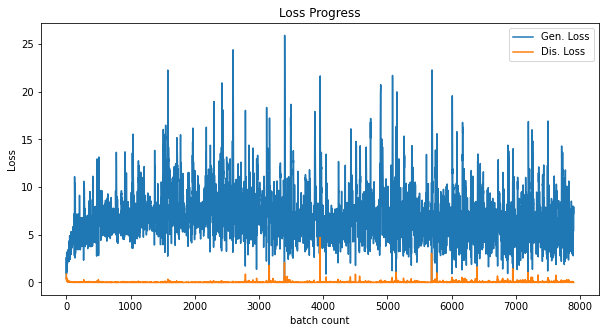

In [84]:
# batch데이터별 Loss변화 기록을 출력한다
plt.figure(figsize=(10,5))
plt.title("Loss Progress")
plt.plot(loss_history['gen'], label="Gen. Loss")
plt.plot(loss_history['dis'], label="Dis. Loss")
plt.xlabel("batch count")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [85]:
# 학습된 가중치를 저장한다
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

In [86]:
# 학습된 가중치 불러오기
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

<All keys matched successfully>

In [87]:
# evalutaion mode
model_gen.eval()

# fake image 생성
with torch.no_grad():
    fixed_noise = torch.randn(16, 100,1,1, device=device)
    label = torch.randint(0,10,(16,), device=device)
    img_fake = model_gen(fixed_noise).detach().cpu()
print(img_fake.shape)

torch.Size([16, 3, 64, 64])


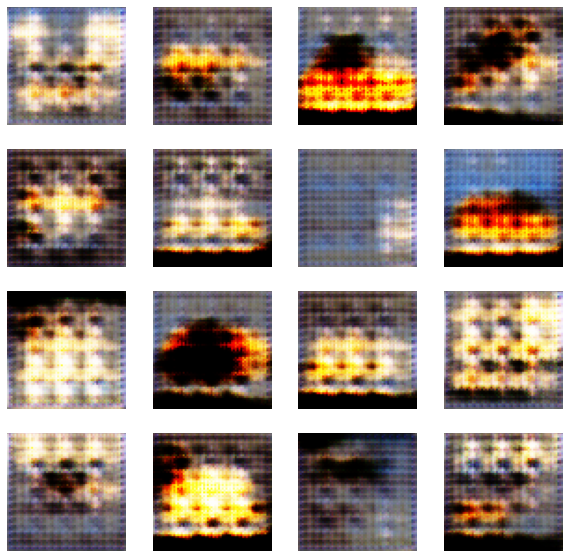

In [89]:
# 가짜 이미지 시각화
plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5),)
    plt.axis('off')